In [2]:
import gdown
gdown.download(id='17ZPaP0S9Ow2RMlgECyhw38lr_bpATgj2')
!unzip /content/empirical_data.zip
!rm /content/empirical_data.zip


# @title Download Data

Downloading...
From (original): https://drive.google.com/uc?id=17ZPaP0S9Ow2RMlgECyhw38lr_bpATgj2
From (redirected): https://drive.google.com/uc?id=17ZPaP0S9Ow2RMlgECyhw38lr_bpATgj2&confirm=t&uuid=bd0d3169-1eed-4626-9149-b7714e715291
To: /content/empirical_data.zip
100%|██████████| 704M/704M [00:08<00:00, 87.0MB/s]


Archive:  /content/empirical_data.zip
  inflating: all_eeg_evoked.npy      
  inflating: all_epo_seeg.pkl        
  inflating: dist_Schaefer_1000parcels_7net.pkl  
  inflating: example_epoched.fif     


In [3]:
import sys
!{sys.executable} -m pip install mne > /dev/null
!{sys.executable} -m pip install nilearn > /dev/null
!{sys.executable} -m pip install nibabel > /dev/null

# @title Install dependencies

In [4]:
#python stuffs
import pickle
import numpy as np
import glob
import re
import os
import scipy, sklearn
import numpy as np
import os.path as op
import pandas as pd
from scipy.signal import find_peaks



# plotting stuffs
import matplotlib.pyplot as plt
import seaborn as sns

#neuroimaging stuffs
import mne
import nibabel as nib
from nilearn import plotting
from nilearn import surface
from nilearn.image import load_img


import warnings
warnings.filterwarnings('ignore')


# @title Importage



\begin{equation}
GMFA = \sqrt{\frac{1}{K} \sum_{i}^{k} (V_i(t) - V_{mean}(t))^2}
\end{equation}

In [5]:
all_eeg_evoked = np.load('/content/all_eeg_evoked.npy')
epo_eeg = mne.read_epochs('/content/example_epoched.fif', verbose=False)

all_gfma = np.zeros((all_eeg_evoked.shape[0], all_eeg_evoked.shape[2]))

for ses in range(all_eeg_evoked.shape[0]):
    all_gfma[ses,:] =  np.std(all_eeg_evoked[ses,:,:],axis=0) #np.mean(np.mean(epo_eeg._data, axis=0),axis=0)
    #Normalized for the baseline for making comparison
    all_gfma[ses,:] = np.abs(all_gfma[ses,:] - np.mean(all_gfma[ses, :300]))

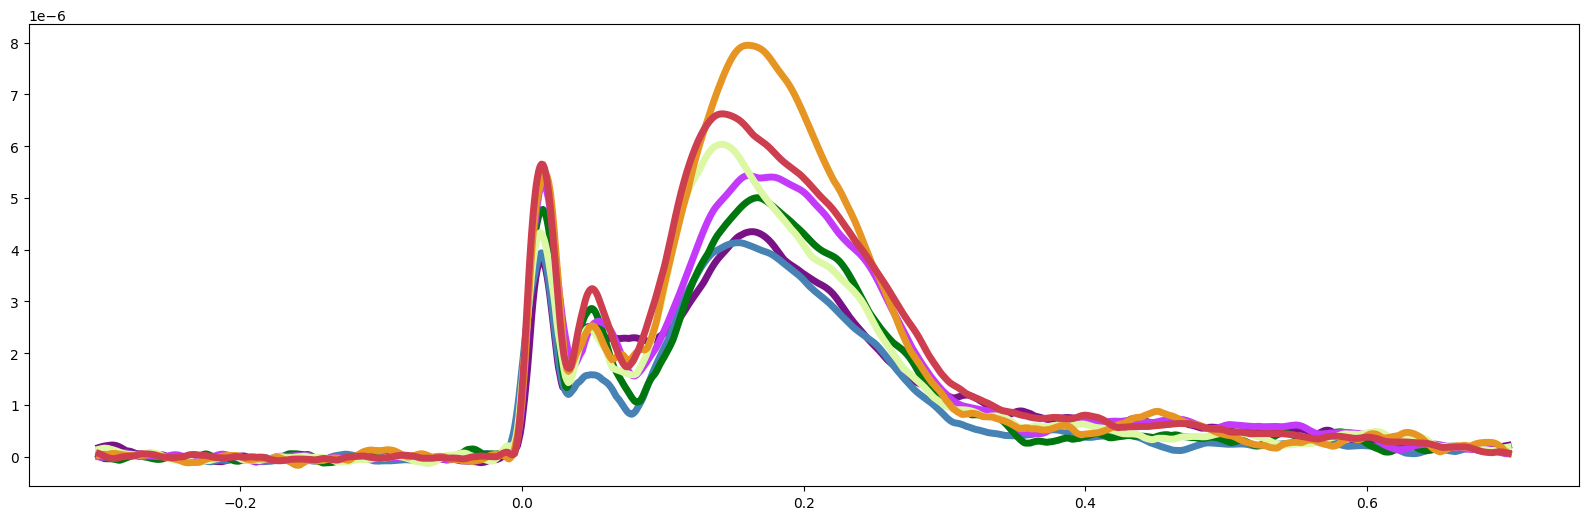

In [6]:
with open('/content/dist_Schaefer_1000parcels_7net.pkl', 'rb') as handle:
    dist_Schaefer_1000parcels_7net = pickle.load(handle)
stim_region = dist_Schaefer_1000parcels_7net['stim_region']


networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
# Create a dictionary to store the network indices
stim_network_indices = {network: [] for network in networks}
for i, label in enumerate(stim_region):
    # Iterate over each network
    for network in networks:
        if network in label:
            stim_network_indices[network].append(i)
            break

net_gfma = {}

for network in networks:
    net_gfma[network] = all_gfma[stim_network_indices[network]]


averages = []

for key, value in net_gfma.items():
    average = sum(value) / len(value)
    averages.append(average)

averages = np.array(averages)

# Download the file from the GitHub URL
url = 'https://github.com/Davi1990/DissNet/raw/main/examples/network_colour.xlsx'
colour = pd.read_excel(url, header=None)[4]

# Define the desired figure size
fig = plt.figure(figsize=(20, 6))

# Plot the data
for net in range(len(networks)):
    plt.plot(epo_eeg.times, averages[net, :] - np.mean(averages[net, :300]), colour[net], linewidth=5)

# Display the plot
plt.show()

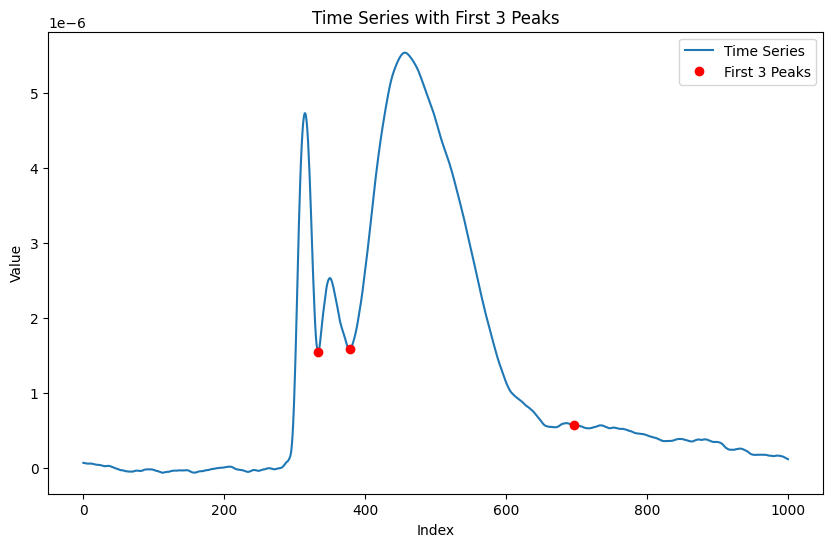

In [7]:
# Calculate the mean array as you mentioned
time_series = np.mean((averages[:, :] - np.mean(averages[:, :300])), axis=0)

# Find peaks in the time series data
peaks, _ = find_peaks(-time_series[:700], distance=1)  # Adjust 'distance' parameter as needed

peak_values = time_series[peaks]

# Get the indices of the first 3 peaks in descending order of amplitude
first_3_peak_indices = peaks[np.argsort(peak_values)[::-1][:3]]

# Get the actual values of the first 3 peaks
first_3_peak_amplitudes = peak_values[np.argsort(peak_values)[::-1][:3]]

# Plot the time series and the identified peaks
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Time Series')
plt.plot(first_3_peak_indices, first_3_peak_amplitudes, 'ro', label='First 3 Peaks')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Time Series with First 3 Peaks')
plt.show()

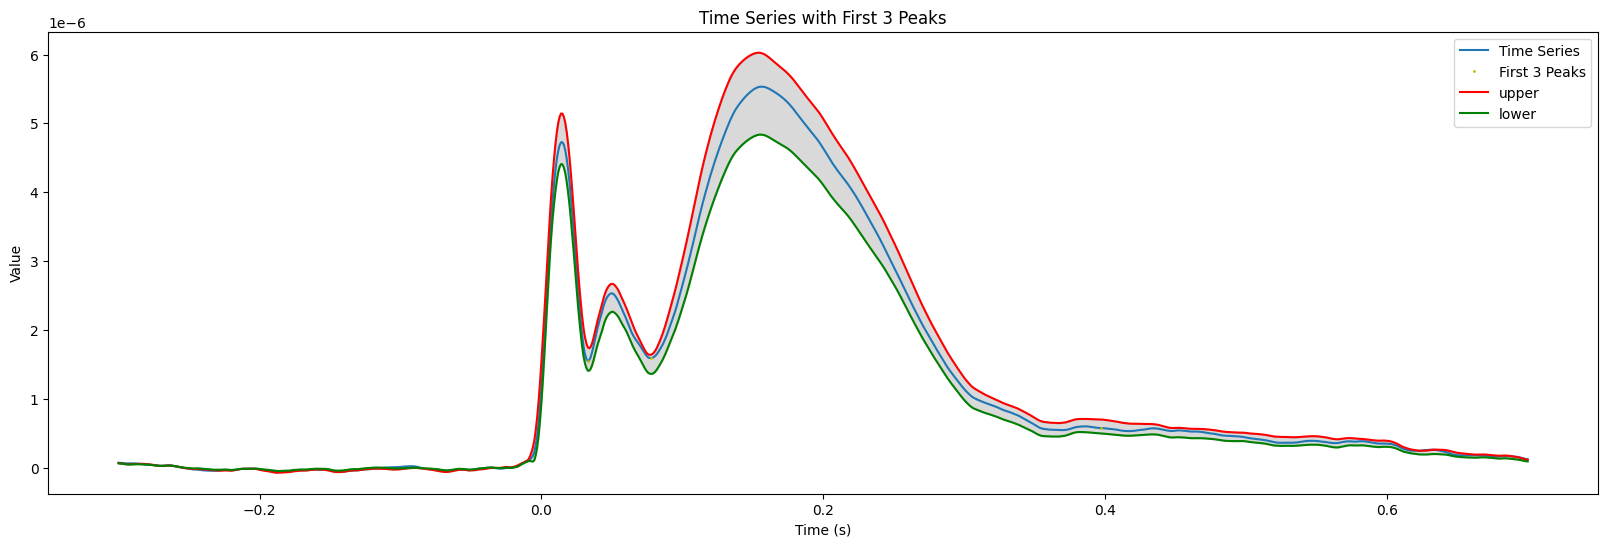

In [8]:
# Assuming you have a 2D array all_gfma with shape (323, 1001)
# Calculate the mean and standard deviation along the first axis (sessions)
mean_all_gfma = np.mean(all_gfma, axis=0)
std_all_gfma = np.std(all_gfma, axis=0)
# Calculate the margin of error for the confidence interval
confidence_level = 0.95
z_score = 1.96  # For a 95% confidence interval
margin_of_error = z_score * (std_all_gfma / np.sqrt(len(all_gfma)))

# Calculate the upper and lower bounds of the confidence interval
upper_bound = mean_all_gfma + margin_of_error
lower_bound = mean_all_gfma - margin_of_error


upper_bound =upper_bound - np.mean(upper_bound[:300])
lower_bound =lower_bound - np.mean(lower_bound[:300])


if len(epo_eeg.times) == len(time_series):
    # Plot the time series and the identified peaks
    plt.figure(figsize=(20, 6))
    plt.plot(epo_eeg.times, time_series, label='Time Series')
    plt.plot(epo_eeg.times[first_3_peak_indices], first_3_peak_amplitudes, 'yo', markersize=1, label='First 3 Peaks')
    plt.plot(epo_eeg.times, upper_bound,'-r', label='upper')
    plt.plot(epo_eeg.times, lower_bound,'-g', label='lower')
    plt.fill_between(epo_eeg.times, upper_bound, lower_bound, color="k", alpha=0.15)  # Use 'epo_eeg.times'

    plt.legend()
    plt.xlabel('Time (s)')  # Set the x-axis label to 'Time (s)'
    plt.ylabel('Value')
    plt.title('Time Series with First 3 Peaks')
    #plt.savefig('C:/Users/davide_momi/Desktop/peaks.png', dpi=300)
    plt.show()
else:
    print("The lengths of 'epo_eeg.times' and 'time_series' don't match.")



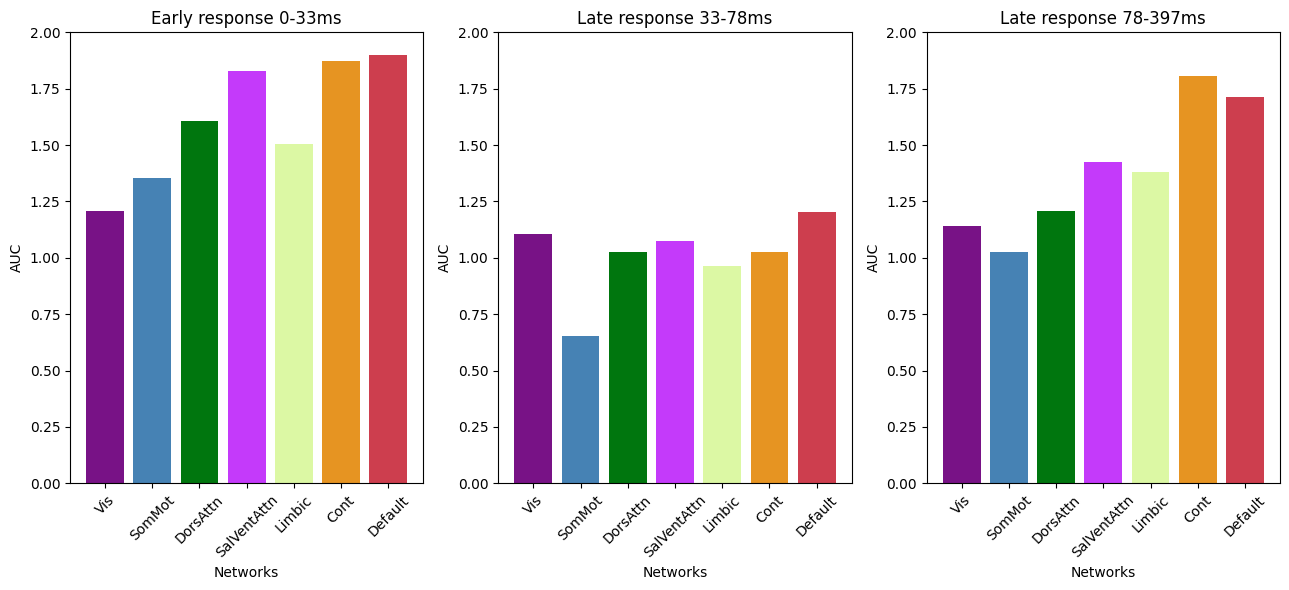

In [9]:
windows = 3
AUC = np.zeros((3,all_gfma.shape[0]))

first_3_peak_indices_sorted = sorted(first_3_peak_indices)
first_peak = epo_eeg.times[first_3_peak_indices_sorted[0]]
second_peak = epo_eeg.times[first_3_peak_indices_sorted[1]]
third_peak = epo_eeg.times[first_3_peak_indices_sorted[2]]


for ses in range(all_gfma.shape[0]):
    AUC[0, ses] = np.trapz(all_gfma[ses, np.where(epo_eeg.times==0)[0][0]:np.where(epo_eeg.times==first_peak)[0][0]]
                           - np.mean(all_gfma[ses, :300]), dx=5)
    AUC[1, ses] = np.trapz(all_gfma[ses, np.where(epo_eeg.times==first_peak)[0][0]:np.where(epo_eeg.times==second_peak)[0][0]]
                           - np.mean(all_gfma[ses, :300]), dx=5)
    AUC[2, ses] = np.trapz(all_gfma[ses, np.where(epo_eeg.times==second_peak)[0][0]:np.where(epo_eeg.times==third_peak)[0][0]]
                           - np.mean(all_gfma[ses, :300]), dx=5)

AUC[0,:] = AUC[0,:] / (first_3_peak_indices_sorted[0] - 300)
AUC[1,:] = AUC[1,:] / (first_3_peak_indices_sorted[1] - first_3_peak_indices_sorted[0])
AUC[2,:] = AUC[2,:] / (first_3_peak_indices_sorted[2] - first_3_peak_indices_sorted[1])


net_AUC = {}

for network in networks:
    net_AUC[network] = AUC[:,stim_network_indices[network]]


AUC_averages = np.zeros((len(networks), windows))

for idx, key in enumerate(net_AUC.keys()):
    AUC_averages[idx, :] = np.mean(net_AUC[key], axis=1)

AUC_averages = AUC_averages *100000


# Download the file from the GitHub URL
url = 'https://github.com/Davi1990/DissNet/raw/main/examples/network_colour.xlsx'
colour = pd.read_excel(url, header=None)[4]



# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(13, 6))  # 2 rows, 1 column

# Plot in the first subplot
axs[0].bar(range(AUC_averages[:, 1].shape[0]), AUC_averages[:, 0], color=colour)
axs[0].set_xticks(range(AUC_averages[:, 0].shape[0]))
axs[0].set_xticklabels(networks, rotation=45)
axs[0].set_xlabel('Networks')
axs[0].set_title('Early response 0-' + str(round(first_peak*1000)) + 'ms')
axs[0].set_ylabel('AUC')
axs[0].set_ylim(0, 2)  # Adjust the y-axis limits as needed

# Plot in the second subplot (same as the first subplot)
axs[1].bar(range(AUC_averages[:, 1].shape[0]), AUC_averages[:, 1], color=colour)
axs[1].set_xticks(range(AUC_averages[:, 0].shape[0]))
axs[1].set_xticklabels(networks, rotation=45)
axs[1].set_xlabel('Networks')
axs[1].set_title('Late response ' + str(round(first_peak*1000)) + '-' + str(round(second_peak*1000)) + 'ms')
axs[1].set_ylabel('AUC')
axs[1].set_ylim(0, 2)  # Adjust the y-axis limits as needed


# Plot in the second subplot (same as the first subplot)
axs[2].bar(range(AUC_averages[:, 2].shape[0]), AUC_averages[:, 2], color=colour)
axs[2].set_xticks(range(AUC_averages[:, 0].shape[0]))
axs[2].set_xticklabels(networks, rotation=45)
axs[2].set_xlabel('Networks')
axs[2].set_title('Late response ' + str(round(second_peak*1000)) + '-' + str(round(third_peak*1000)) + 'ms')
axs[2].set_ylabel('AUC')
axs[2].set_ylim(0, 2)  # Adjust the y-axis limits as needed

plt.tight_layout()  # Adjust the spacing between subplots if needed


plt.show()


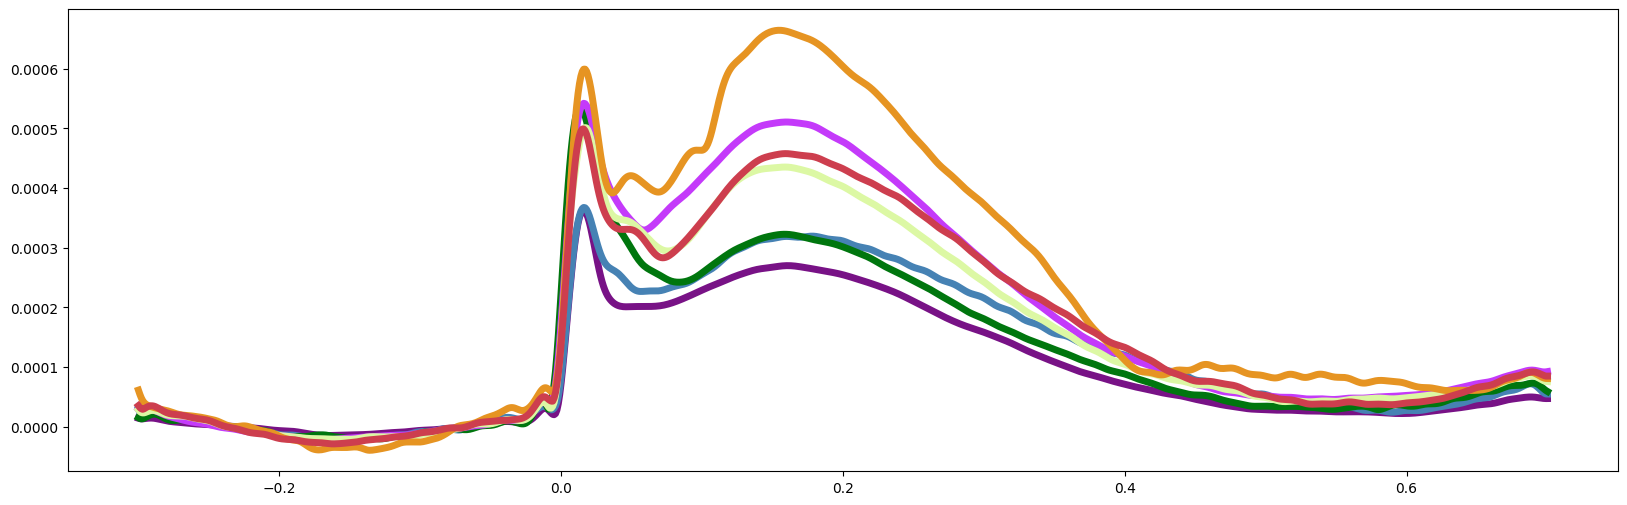

In [10]:
with open('/content/all_epo_seeg.pkl', 'rb') as handle:
    all_epo_seeg = pickle.load(handle)


all_gfma = np.zeros((len(list(all_epo_seeg.keys())), epo_eeg._data.shape[2]))

for ses in range(len(list(all_epo_seeg.keys()))):
    epo_seeg =all_epo_seeg[list(all_epo_seeg.keys())[ses]]
    for xx in range(epo_seeg.shape[0]):
        epo_seeg[xx,:] = epo_seeg[xx,:] - np.mean(epo_seeg[xx,:300])

    all_gfma[ses,:] =  np.std(epo_seeg, axis=0)


with open('/content/dist_Schaefer_1000parcels_7net.pkl', 'rb') as handle:
    dist_Schaefer_1000parcels_7net = pickle.load(handle)
stim_region = dist_Schaefer_1000parcels_7net['stim_region']

networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
# Create a dictionary to store the network indices
stim_network_indices = {network: [] for network in networks}
for i, label in enumerate(stim_region):
    #if dist_Schaefer_1000parcels_7net['dist'][i] < 7:
            # Iterate over each network
            for network in networks:
                if network in label:
                    stim_network_indices[network].append(i)
                    break


net_gfma = {}

for network in networks:
    net_gfma[network] = all_gfma[stim_network_indices[network]]


averages = []

for key, value in net_gfma.items():
    average = sum(value) / len(value)
    averages.append(average)

averages = np.array(averages)

# Download the file from the GitHub URL
url = 'https://github.com/Davi1990/DissNet/raw/main/examples/network_colour.xlsx'
colour = pd.read_excel(url, header=None)[4]

# Define the desired figure size
fig = plt.figure(figsize=(20, 6))

# Plot the data
for net in range(len(networks)):
    plt.plot(epo_eeg.times, averages[net, :] - np.mean(averages[net, :300]), colour[net], linewidth=5)

# Display the plot


plt.show()

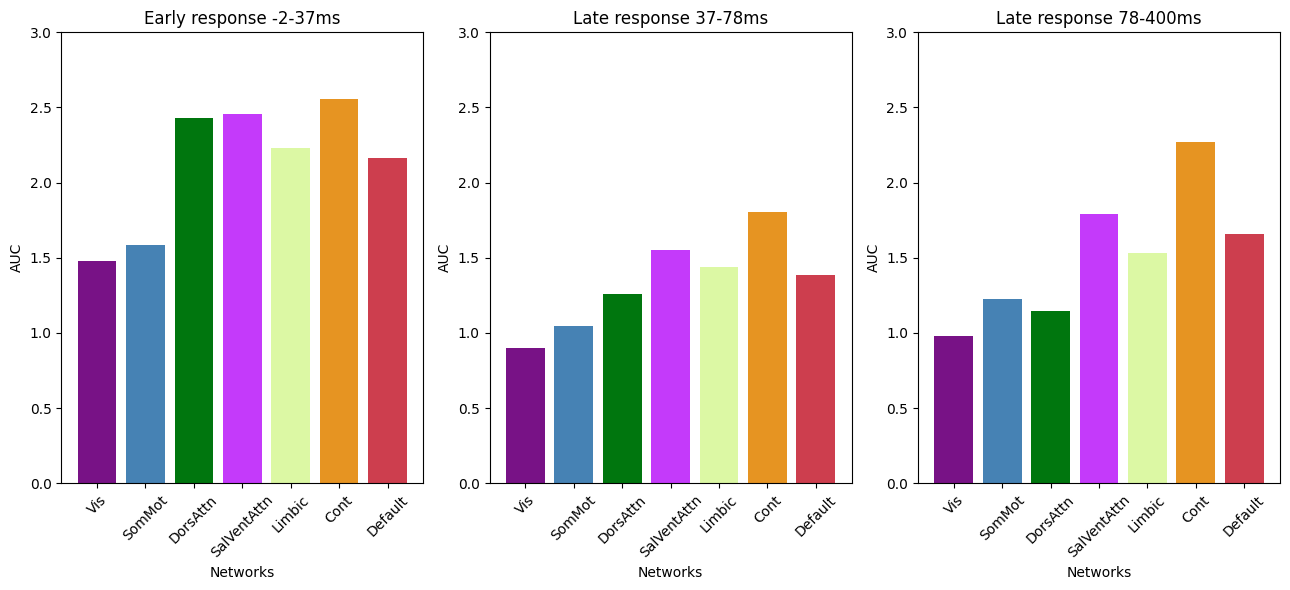

In [11]:
# Calculate the mean array as you mentioned
time_series = np.mean((averages[:, :] - np.mean(averages[:, :300])), axis=0)

# Find peaks in the time series data
peaks, _ = find_peaks(-time_series, width=15)  # Adjust 'distance' parameter as needed

peak_values = time_series[peaks]

# Get the indices of the first 3 peaks in descending order of amplitude
first_3_peak_indices = peaks[np.argsort(peak_values)[::-1][:3]]

first_3_peak_indices = np.array([298, 337, 378, 700])
first_3_peak_amplitudes = time_series[first_3_peak_indices]


windows = 3
AUC = np.zeros((3,all_gfma.shape[0]))

first_peak = epo_eeg.times[first_3_peak_indices[0]]
second_peak = epo_eeg.times[first_3_peak_indices[1]]
third_peak = epo_eeg.times[first_3_peak_indices[2]]
fourth_peak = epo_eeg.times[first_3_peak_indices[3]]


for ses in range(all_gfma.shape[0]):
    AUC[0, ses] = np.trapz(all_gfma[ses, np.where(epo_eeg.times==first_peak)[0][0]:np.where(epo_eeg.times==second_peak)[0][0]]
                           - np.mean(all_gfma[ses, :300]), dx=5)
    AUC[1, ses] = np.trapz(all_gfma[ses, np.where(epo_eeg.times==second_peak)[0][0]:np.where(epo_eeg.times==third_peak)[0][0]]
                           - np.mean(all_gfma[ses, :300]), dx=5)
    AUC[2, ses] = np.trapz(all_gfma[ses, np.where(epo_eeg.times==third_peak)[0][0]:np.where(epo_eeg.times==fourth_peak)[0][0]]
                           - np.mean(all_gfma[ses, :300]), dx=5)



AUC[0,:] = AUC[0,:] / 33
AUC[1,:] = AUC[1,:] / 45
AUC[2,:] = AUC[2,:] / 319

net_AUC = {}

for network in networks:
    net_AUC[network] = AUC[:,stim_network_indices[network]]


AUC_averages = np.zeros((len(networks), windows))

for idx, key in enumerate(net_AUC.keys()):
    AUC_averages[idx, :] = np.mean(net_AUC[key], axis=1)


AUC_averages = AUC_averages*1000
# AUC_averages = (AUC_averages / np.max(AUC_averages, axis=0)) * 100


# Download the file from the GitHub URL
url = 'https://github.com/Davi1990/DissNet/raw/main/examples/network_colour.xlsx'
colour = pd.read_excel(url, header=None)[4]



# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(13, 6))  # 2 rows, 1 column

# Plot in the first subplot
axs[0].bar(range(AUC_averages[:, 1].shape[0]), AUC_averages[:, 0], color=colour)
axs[0].set_xticks(range(AUC_averages[:, 0].shape[0]))
axs[0].set_xticklabels(networks, rotation=45)
axs[0].set_xlabel('Networks')
axs[0].set_title('Early response '+ str(round(first_peak*1000)) + '-' + str(round(second_peak*1000)) + 'ms')
axs[0].set_ylabel('AUC')
axs[0].set_ylim(0, 3)  # Adjust the y-axis limits as needed

# Plot in the second subplot (same as the first subplot)
axs[1].bar(range(AUC_averages[:, 1].shape[0]), AUC_averages[:, 1], color=colour)
axs[1].set_xticks(range(AUC_averages[:, 0].shape[0]))
axs[1].set_xticklabels(networks, rotation=45)
axs[1].set_xlabel('Networks')
axs[1].set_title('Late response ' + str(round(second_peak*1000)) + '-' + str(round(third_peak*1000)) + 'ms')
axs[1].set_ylabel('AUC')
axs[1].set_ylim(0, 3)  # Adjust the y-axis limits as needed


# Plot in the second subplot (same as the first subplot)
axs[2].bar(range(AUC_averages[:, 2].shape[0]), AUC_averages[:, 2], color=colour)
axs[2].set_xticks(range(AUC_averages[:, 0].shape[0]))
axs[2].set_xticklabels(networks, rotation=45)
axs[2].set_xlabel('Networks')
axs[2].set_title('Late response ' + str(round(third_peak*1000)) + '-' + str(round(fourth_peak*1000)) + 'ms')
axs[2].set_ylabel('AUC')
axs[2].set_ylim(0, 3)  # Adjust the y-axis limits as needed

plt.tight_layout()
plt.show()